In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dropout, LayerNormalization, MultiHeadAttention, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Data Preprocessing

def preprocess_data(file_path):
    data = pd.read_csv(file_path, nrows = 60000)

    #lower case all words
    eng_text = data['English words/sentences'].apply(lambda x: x.lower().strip())
    french_text = data['French words/sentences'].apply(lambda x: x.lower().strip())

    #create a tokenizer
    eng_tokenizer = Tokenizer()
    french_tokenizer = Tokenizer()

    #assign an integer to each word
    eng_tokenizer.fit_on_texts(eng_text)
    french_tokenizer.fit_on_texts(french_text)

    #assign an array of integers to each sentence
    eng_sequences = eng_tokenizer.texts_to_sequences(eng_text)
    french_sequences = french_tokenizer.texts_to_sequences(french_text)

    #finding the maximum sentence length
    max_eng_len = max(len(seq) for seq in eng_sequences)
    max_french_len = max(len(seq) for seq in french_sequences)

    #adding 0 to the end of each sentence array to ensure equal length
    eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
    french_padded = pad_sequences(french_sequences, maxlen=max_french_len, padding='post')

    #splitting the data
    eng_train, eng_temp, french_train, french_temp = train_test_split(eng_padded, french_padded, test_size=0.2, random_state=42)
    eng_val, eng_test, french_val, french_test = train_test_split(eng_temp, french_temp, test_size=0.5, random_state=42)

    return eng_train, eng_val, eng_test, french_train, french_val, french_test, eng_tokenizer, french_tokenizer, max_eng_len, max_french_len


In [4]:
file_path = '/content/eng-french.csv'
eng_train, eng_val, eng_test, french_train, french_val, french_test, eng_tokenizer, french_tokenizer, max_eng_len, max_french_len = preprocess_data(file_path)

#vocabulary sizes
input_vocab_size = len(eng_tokenizer.word_index) + 1
target_vocab_size = len(french_tokenizer.word_index) + 1

In [5]:
def positional_encoding(max_len, d_model):
    pos_encoding = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_encoding[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_causal_mask(size):
    mask = np.triu(np.ones((size, size)), k=1)
    return tf.cast(mask == 0, dtype=tf.float32)

In [8]:
#model
def transformer_model(input_vocab_size, target_vocab_size, input_max_len, target_max_len, embedding_dim=256, num_heads=4, feed_forward_dim=512):

    # Encoder
    inputs = Input(shape=(input_max_len,))
    enc_emb = Embedding(input_vocab_size, embedding_dim)(inputs)
    positional_encoding_input = positional_encoding(input_max_len, embedding_dim)
    enc_emb = enc_emb + positional_encoding_input

    for _ in range(2):
        # Multi-Head Attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(enc_emb, enc_emb, enc_emb)
        # Add & Norm
        norm_1 = LayerNormalization()(attn_output)
        add_1 = norm_1 + enc_emb
        # Feed Forward Network
        ffn_output = Dense(feed_forward_dim, activation='relu')(add_1)
        ffn_output = Dense(embedding_dim)(ffn_output)
        # Add & Norm
        norm_2 = LayerNormalization()(ffn_output)
        add_2 = norm_2 + add_1
        enc_emb = add_2
    enc_output = enc_emb

    # Decoder
    dec_inputs = Input(shape=(target_max_len,))
    dec_emb = Embedding(target_vocab_size, embedding_dim)(dec_inputs)
    positional_encoding_target = positional_encoding(target_max_len, embedding_dim)
    dec_emb = dec_emb + positional_encoding_target

    for _ in range(2):
        # Masked Multi-Head Attention (Self-Attention)
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(dec_emb, dec_emb, dec_emb, attention_mask=create_causal_mask(target_max_len))
        # Add & Norm
        norm_1 = LayerNormalization()(attn_output)
        add_1 = dec_emb + norm_1
        # Encoder-Decoder Attention
        enc_dec_attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(add_1, enc_output, enc_output)
        # Add & Norm
        norm_2 = LayerNormalization()(enc_dec_attn_output)
        add_2 = norm_1 + add_1
        # Feed Forward Network
        ffn_output = Dense(feed_forward_dim, activation='relu')(add_2)
        ffn_output = Dense(embedding_dim)(ffn_output)
        # Add & Norm
        norm_3 = LayerNormalization()(ffn_output)
        add_3 = ffn_output + norm_3
        dec_emb = add_3
    dec_output = dec_emb

    # Final Dense Layer
    output = Dense(target_vocab_size, activation='softmax')(dec_output)
    model = Model(inputs=[inputs, dec_inputs], outputs=output)
    return model


# Instantiate and compile model
model = transformer_model(input_vocab_size, target_vocab_size, max_eng_len, max_french_len)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [eng_train, french_train],
    np.expand_dims(french_train, -1),
    epochs=10,
    batch_size=64,
    validation_data=([eng_val, french_val], np.expand_dims(french_val, -1))
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7822 - loss: 1.6869 - val_accuracy: 0.9533 - val_loss: 0.3502
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9334 - loss: 0.4752 - val_accuracy: 0.9647 - val_loss: 0.2900
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9608 - loss: 0.2602 - val_accuracy: 0.9720 - val_loss: 0.2403
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9763 - loss: 0.1465 - val_accuracy: 0.9739 - val_loss: 0.2199
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9771 - loss: 0.1233 - val_accuracy: 0.9757 - val_loss: 0.2097
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9815 - loss: 0.0930 - val_accuracy: 0.9773 - val_loss: 0.2100
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9815 - loss: 0.0852 - val_accuracy: 0.9662 - val_loss: 0.2408
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9827 - loss: 0.0744 - 

In [9]:

# Training and Evaluation
def evaluate_model(model, eng_test, french_test, eng_tokenizer, french_tokenizer):
    # Predicting the French sentences
    french_pred = model.predict([eng_test, french_test])
    french_pred_text = [
        french_tokenizer.sequences_to_texts([np.argmax(pred, axis=-1)])[0]
        for pred in french_pred
    ]

    # Decoding the French sentences
    french_test_decoded = [
        ' '.join([french_tokenizer.index_word[token] for token in sentence if token != 0])
        for sentence in french_test
    ]

    # Prepare references and hypotheses for BLEU score calculation
    references = [[sent.split()] for sent in french_test_decoded]
    hypotheses = [sent.split() for sent in french_pred_text]

    # BLEU score calculation
    smoothing = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing)
    print(f'BLEU Score: {bleu_score}')
    # Print the original and predicted translations
    for i in range(5):  # Print the first 5 samples (you can adjust this number)
        print(f"Original: {french_test_decoded[i]}")
        print(f"Predicted: {french_pred_text[i]}")
        print('-' * 50)


# Evaluate the model
evaluate_model(model, eng_test, french_test, eng_tokenizer, french_tokenizer)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
BLEU Score: 0.8748720654198033
Original: je vais en ville
Predicted: je vais en ville
--------------------------------------------------
Original: les chaussures se vendent par paires
Predicted: les chaussures se dames  par réussirait
--------------------------------------------------
Original: nous étions chanceux
Predicted: nous étions chanceux
--------------------------------------------------
Original: conte moi une histoire pour m'endormir
Predicted: conte moi une histoire pour poserai
--------------------------------------------------
Original: restons calmes
Predicted: restons calmes
--------------------------------------------------


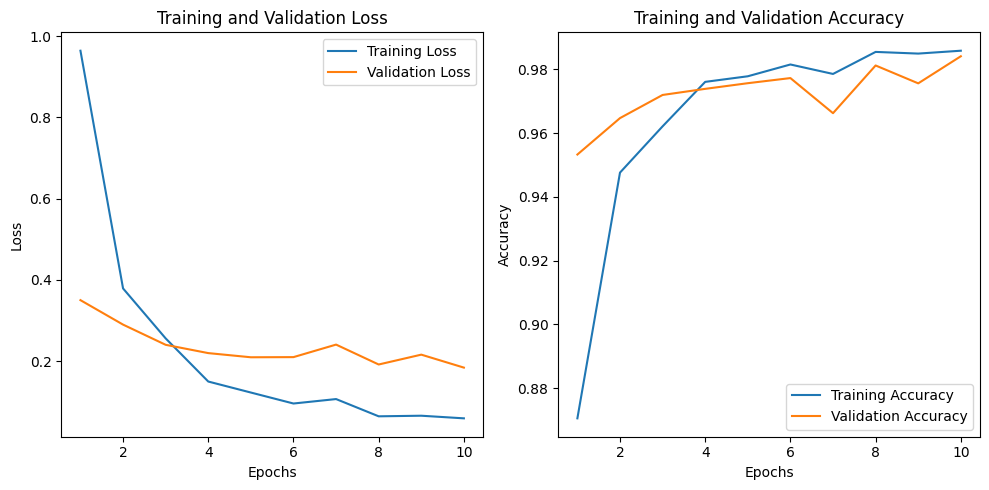

In [10]:
def plot_loss_and_accuracy(history):
    epochs = range(1, len(history.history['loss']) + 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)